# Regression analysis of various combination of variables in the SAMW layer

### Compare
- Average temperature in SAMW layer against layer thickness anomaly
- Average temperature against ageostrophic velocity vectors
- layer thickness anomaly against ageostrophic velocity vectors
- Average temperature against rotation between ADCP and geostrophic velocity vectors

In [1]:
%run ../../_setup.py

from netCDF4 import Dataset, num2date

import numpy as np
from scipy.interpolate import interp1d, griddata

import xarray as xr
import pyproj
# from OceanPy.kinematics import gradient_wind_from_ssh
# from OceanPy.interpolation import polyfit1d

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cmocean as cmo

In [2]:
savefig = False

fs_small = 12
fs_large = 14
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('text', usetex=True)
plt.style.use('default')

In [3]:
def density_layer(gamman, variable, bounds=(None, None)):
    
    nprof, npres = gamman.shape
        
    def interp(xp, yp, xi):

        xp = np.ma.masked_invalid(xp)
        yp = np.ma.masked_invalid(yp)
        mask = xp.mask | yp.mask
        
        if all(mask):
            yi = np.ma.masked_all(xi.shape)
        else:
            f = interp1d(xp[~mask], yp[~mask], bounds_error=False)
            yi = f(xi)
            
        return yi
    
    def find_nearest(array, value):
        idx = np.nanargmin(np.abs(array - value))
        return idx
    
    # make monotonically increasing equidistant density coordinate
    gni = np.linspace(np.nanmin(gamman), np.nanmax(gamman), npres)
    
    # interpolate variable on density coordinate
    variable_gn = np.ma.masked_all((nprof, npres))
    for i in range(nprof):
        variable_gn[i,] = interp(gamman[i,], variable[i,], gni)
    
    # find indices of layer boundaries
    if bounds[0] and bounds[1]:
        idx = np.arange(find_nearest(gni, bounds[0]), find_nearest(gni, bounds[1]) + 1)
        
    elif bounds[0] or bounds[1]:
        try:
            idx = find_nearest(gni, bounds[0])
        except TypeError:
            idx = find_nearest(gni, bounds[1])
    else:
        idx = None
    
    return gni, variable_gn, idx


In [4]:
def Rsquared(var_x, var_y, deg=1, mask=None):
    
    mask_x, mask_y = np.ma.masked_invalid(var_x).mask, np.ma.masked_invalid(var_y).mask
    mask = np.zeros(mask_x.shape, dtype=bool) if mask is None else mask
    mask = mask | mask_x | mask_y

    coef = np.polyfit(var_x[~mask], var_y[~mask], deg)
    f = np.poly1d(coef)
    
    # coefficient of determination
    SSres = np.sum((var_y[~mask] - f(var_x)[~mask])**2)
    SStot = np.sum((var_y[~mask] - np.nanmean(var_y[~mask]))**2)
    
    R2 = 1 - (SSres/SStot)
    
    return R2, f

In [5]:
def figure(var_x, var_y, attributes, var_attr, mask=None, weird=False):

    R2, f = Rsquared(var_x, var_y, mask=mask)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    areas = ['into trough', 'in between', 'into crest', 'outliers']
    for area in areas:
        istat, color, marker = front_loc[area]
        if area is not 'outliers':
            istat = [i for i in istat if i not in ioutliers]
        ax[0].scatter(var_x[istat], var_y[istat], 
                      s=50, facecolors=color, edgecolors='k', marker=marker, label=area)
    
    if weird:
        ax[0].scatter(var_x[front_loc['weird'][0]], var_y[front_loc['weird'][0]], 
                          s=200, linewidth=2, facecolors='none', edgecolors='k', label='weird')
    xi = np.linspace(*attributes[var_attr][0])
    try:
        ax[0].plot(xi, f(xi), 'k--', label=r'$R^2 = $ %s' %round(float(R2),2))
    except TypeError:
        ax[0].plot(xi, f(xi), 'k--', label=r'$R^2 = $ %s' %round(R2.values,2))


    areas = ['north', 'south', 'outliers']
    for area in areas:
        istat, color, marker = front_loc[area]
        ax[1].scatter(var_x[istat], var_y[istat], 
                      s=80, facecolors=color, edgecolors='k', marker=marker, label=area)

    for iax in range(len(ax)):
        ax[iax].axhline(0, linestyle='--', linewidth=0.5, color='k')
        ax[iax].axvline(0, linestyle='--', linewidth=0.5, color='k')

        ax[iax].set_ylim(attributes[var_attr][1])
        ax[iax].set_ylabel(attributes[var_attr][3])
        ax[iax].set_xlim(attributes[var_attr][0])
        ax[iax].set_xlabel(attributes[var_attr][2])

        ax[iax].legend()
    
    return fig, ax

In [6]:
# load ctd and gsw data
input_file_ctd = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file_ctd, 'r')

# load adcp data
input_file_adcp_mld = os.path.join(datadir, 'ss9802', 'processed', 'adcp', 'ss9802_adcp_ctd_mld.nc')
adcp_ctd = xr.open_dataset(input_file_adcp_mld)
adcp_mld = xr.open_dataset(input_file_adcp_mld, group='MLD')

# load gem
input_file_gem = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gem.nc')
gem = Dataset(input_file_gem, 'r')

# load altimetry/ ssh data
input_file_ssh_ctd = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_ss9802_ctd.nc')
ssh = xr.open_dataset(input_file_ssh_ctd)
ssh_ctd = xr.open_dataset(input_file_ssh_ctd, group='CTD')

# load gradient wind data
input_file_gw = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_ss9802_gw_ctd.nc')
gw = xr.open_dataset(input_file_gw, group='GW')
gw_ctd = xr.open_dataset(input_file_gw, group='CTD')

# load quasi-geostrophic vorticity terms
input_file_qgvb = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_ss9802_qgvb_ctd.nc')
qgvb_ctd = xr.open_dataset(input_file_qgvb, 'CTD')

# input_file_qgvb = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_135_-53_149_-47_199803_qgvb.nc')
input_file_qgvb = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_137_-52_147_-48_199803_qgvb.nc')
qgvb = xr.open_dataset(input_file_qgvb, 'QGVB')


In [7]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


In [8]:
# CTD dimensions
lon_ctd, lat_ctd = ctd['lon'][:, 0], ctd['lat'][:, 0]
time = num2date(ctd['time'][:, 0], ctd['time'].units)
# time_str = [t.strftime('%Y-%m-%d') for t in time]
time_voy = slice('1998-03-12', '1998-03-28')

# ageostrophic components at CTD locations
uag = gw.ugrad - gw.ugeos
vag = gw.vgrad - gw.vgeos

uag_ctd = gw_ctd.ugrad - gw_ctd.ugeos
vag_ctd = gw_ctd.vgrad - gw_ctd.vgeos

In [9]:
# outliers in GEM
outliers = [1, 2, 9, 10, 11, 12, 27, 45, 46, 47, 75, 76, 77, 78, 101]
ioutliers = np.array([istat for istat, station in enumerate(ctd['station']) if station in outliers])
booloutliers = [True if istat in ioutliers else False for istat in range(ctd['station'].size)]

front_loc = {
    'into crest': (range(2, 35), 'darkorange', 'o'),
    'in between': (range(35, 68), 'gray', 'v'),
    'into trough': (range(68, 101), 'dodgerblue', 'D'),
    'north': (np.where(D > 1.45)[0], 'deeppink', '^'), 
    'south': (np.where(D <= 1.45)[0], 'forestgreen', 's'),
    'outliers': (ioutliers, 'gold', 'p'),
    'weird': ([15, 16, 17, 18, 19] + [76, 77, 78] + list(range(88, 96)), 'purple', 'd')
}

attributes = {
    'lt_CT': [(-80, 80), (-1.25, 1.25), 'layer thickness anomaly', 'average CT anomaly in layer', 'lt_anom', 'CT_anom'],
    'dV_CT': [(-9, 9), (-1.25, 1.25), 'normalised ageostrophic velocity', 'average CT anomaly in layer', 'dV', 'CT_anom'],
    'dV_lt': [(-9, 9), (-90, 90), 'normalised ageostrophic velocity', 'layer thickness anomaly', 'dV', 'lt_anom'],
    'ddir_CT': [(-110, 110), (-1.25, 1.25), 'rotation between ADCP and geostrophic velocity vectors', 'average CT anomaly in layer', 'ddir', 'CT_anom']
}


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


In [10]:
# booloutliers = booloutliers | np.array([True if i in front_loc['weird'][0] else False for i in range(len(ctd['station']))])

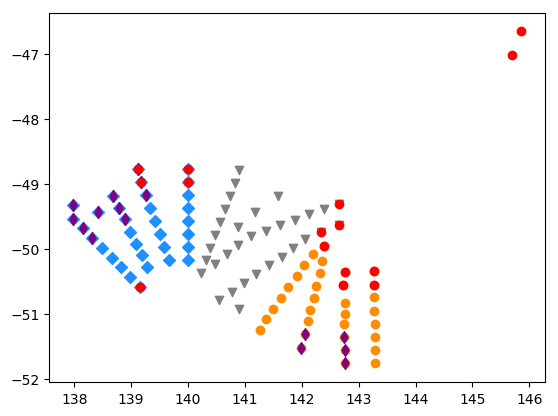

In [11]:
fig, ax = plt.subplots()
areas = ['into trough', 'in between', 'into crest', 'weird']
for area in areas:
    istat, color, marker = front_loc[area]
    ax.scatter(ctd['lon'][istat, 0], ctd['lat'][istat, 0], facecolors=color, marker=marker)

ax.scatter(ctd['lon'][booloutliers, 0], ctd['lat'][booloutliers, 0], facecolors='r')

# Layer thickness of SAMW against layer thickness in GEM (anomaly)

In [12]:
gn_samw = (26.8, 27.35)

gni, h_gn, idx = density_layer(ctd['gamman'], ctd['z'], gn_samw)
_, h_gn_gem, idx_gem = density_layer(gem['gamman'], ctd['z'], gn_samw)

layer_thickness = h_gn[:, idx[0]] - h_gn[:, idx[-1]]
layer_thickness_gem = h_gn_gem[:, idx_gem[0]] - h_gn_gem[:, idx_gem[-1]]
lt_anom = layer_thickness - layer_thickness_gem

Text(0.5, 1.05, 'Layer thickness SAMW (26.8-27.35)')

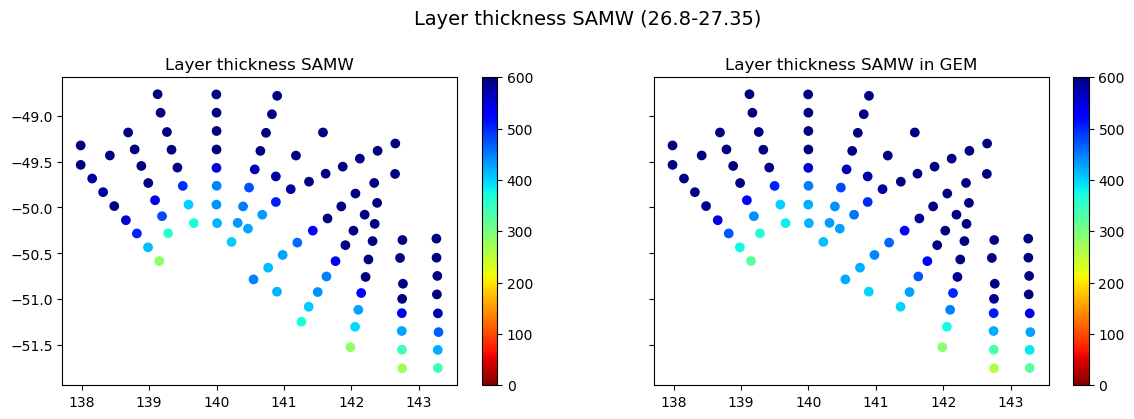

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14,4), sharey=True)
scat = ax[0].scatter(ctd['lon'][2:, 0], ctd['lat'][2:, 0], c=layer_thickness[2:], 
                     cmap=plt.cm.jet_r, vmin=0, vmax=600)
ax[0].set_title('Layer thickness SAMW')
fig.colorbar(scat, ax = ax[0])


scat = ax[1].scatter(ctd['lon'][2:, 0], ctd['lat'][2:, 0], c=layer_thickness_gem[2:], 
                     cmap=plt.cm.jet_r, vmin=0, vmax=600)
fig.colorbar(scat, ax = ax[1])
ax[1].set_title('Layer thickness SAMW in GEM')

fig.suptitle('Layer thickness SAMW (%s-%s)' %(gn_samw), y=1.05, fontsize=14)

Text(0.5, 1.0, 'Ageostrophic velocity vectors with \nSAMW layer thickness ($26.8 \\leq \\gamma_n < 27.35$) difference relative to GEM')

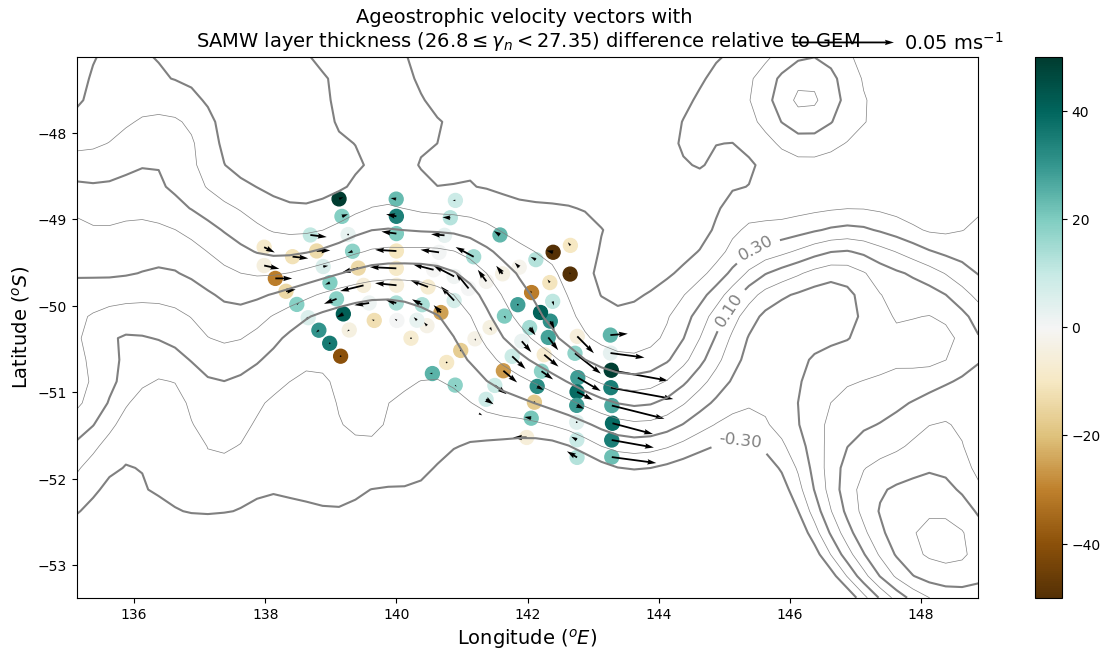

In [14]:
bounds = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
manual = [(145.25, -51.5), (145, -50),  (145.5, -49.35)]
cmap = plt.cm.BrBG

fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
fig.tight_layout()

# pcol = ax.pcolor(ssh.longitude, ssh.latitude, ssh.adt.sel(time=timevoy).mean('time'), cmap=plt.cm.RdYlBu_r)
# fig.colorbar(pcol, ax=ax)

ct = ax.contour(ssh.longitude, ssh.latitude, ssh.adt.sel(time=time_voy).mean('time'), bounds, 
                     colors='gray', linestyles='solid', linewidths=0.5)

scat = ax.scatter(ctd['lon'][2:, 0], ctd['lat'][2:, 0], c=(layer_thickness - layer_thickness_gem)[2:], 
                     cmap=cmap, vmin=-50, vmax=50, s=100)
fig.colorbar(scat)

quiv = ax.quiver(gw_ctd.longitude[2:], gw_ctd.latitude[2:], uag_ctd[2:], vag_ctd[2:], 
                 units='inches', scale=0.05, width=1.5e-3*fig.get_size_inches()[0], color='k')
qk = plt.quiverkey(quiv, .72, 0.99, 0.05, r'0.05 ms$^{-1}$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})


for ib, b in enumerate(bounds):
    if b in bounds[0::2]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=1.5)
ax.clabel(ct, bounds[0::2], inline=1, fontsize=fs_small, fmt='%.2f', manual=manual)

# plot labels
ax.set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
ax.set_ylabel(r'Latitude ($^oS$)', fontsize=fs_large)
ax.set_title('Ageostrophic velocity vectors with \n' + 'SAMW layer thickness ($%s \leq \gamma_n < %s$) difference relative to GEM' %gn_samw, 
             fontsize=fs_large)

## Average temperature in SAMW layer against layer thickness anomaly

In [15]:
_, CT_gn, idx = density_layer(ctd['gamman'], ctd['CT'], gn_samw)
_, CT_gem_gn, idx_gem = density_layer(ctd['gamman'], gem['CT'], gn_samw)

CT_anomaly_SAMW = CT_gn[:, idx] - CT_gem_gn[:, idx_gem]
CT_anom = np.mean(CT_anomaly_SAMW, axis=1)


Text(0.5, 1.0, 'Temperature anomaly between ($26.8 \\leq \\gamma_n < 27.35$)')

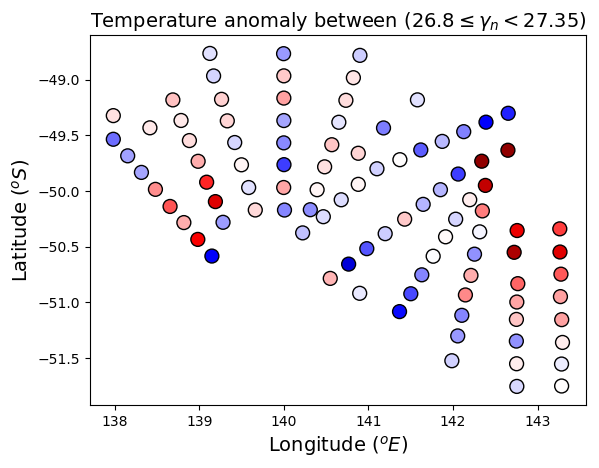

In [40]:
fig, ax = plt.subplots()
ax.scatter(lon_ctd[2:], lat_ctd[2:], c=CT_anom[2:], edgecolors='k', s=100, cmap=plt.cm.seismic, vmin=-0.8, vmax=0.8)
ax.set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
ax.set_ylabel(r'Latitude ($^oS$)', fontsize=fs_large)
ax.set_title('Temperature anomaly between ($%s \leq \gamma_n < %s$)' %gn_samw, 
             fontsize=fs_large)

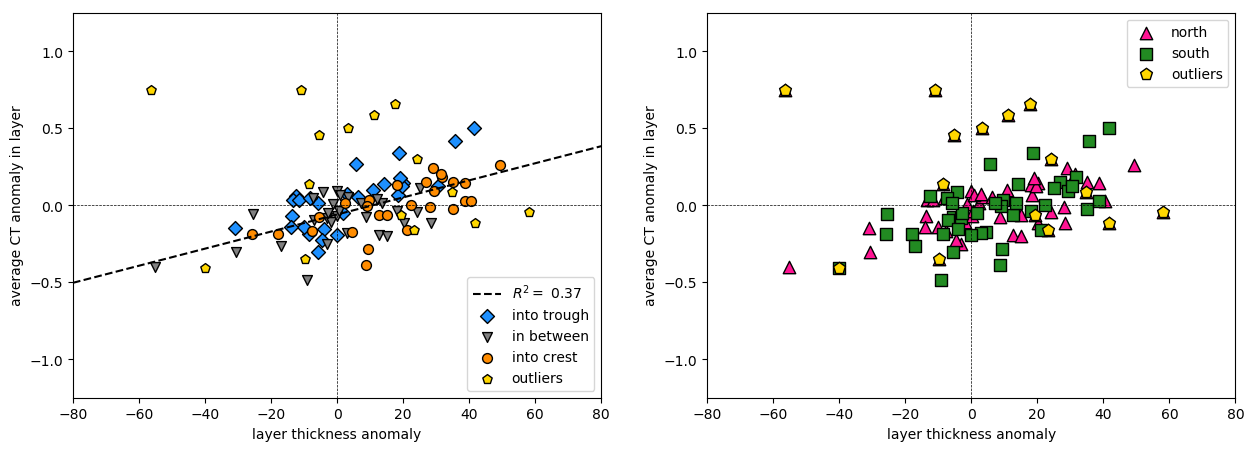

In [17]:
fig, ax = figure(lt_anom, CT_anom, attributes, 'lt_CT', mask=booloutliers)

### keypoints
- Strong correlation between average temperature anomaly in SAMW layer and the layer thickness.

In [18]:
# fig, ax = plt.subplots(figsize=(12,8))

# areas = ['into trough', 'in between', 'into crest']
# for area in areas:
#     istat, color, marker = front_loc[area]
#     if area is not 'outliers':
#         istat = [i for i in istat if i not in ioutliers]
#     ax.scatter(ctd['lon'][istat, 0], avg_CT_anomaly_SAMW[istat], facecolors=color, marker=marker, label=area)

## Average temperature against normalised ageostrophic velocity

In [19]:
gw_ctd['Vgrad'] = np.sqrt(gw_ctd['ugrad']**2 + gw_ctd['vgrad']**2)
gw_ctd['Vgeos'] = np.sqrt(gw_ctd['ugeos']**2 + gw_ctd['vgeos']**2)

dV_ctd = ((gw_ctd['Vgrad'] - gw_ctd['Vgeos']) / gw_ctd['Vgeos']) * 100
dV = np.ma.masked_invalid(dV_ctd)

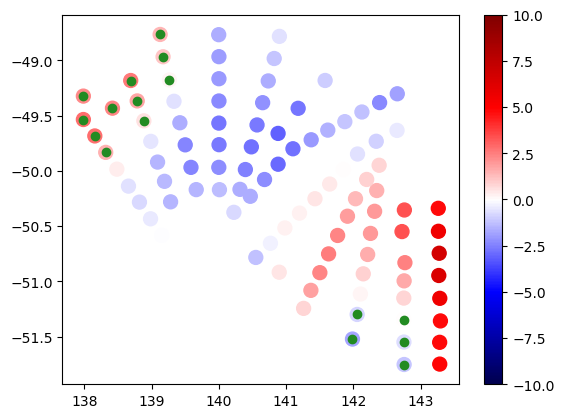

In [20]:
fig, ax = plt.subplots()
scat = ax.scatter(ctd['lon'][2:, 0], ctd['lat'][2:, 0], c=dV[2:], 
                     cmap=plt.cm.seismic, s=100, vmin=-10, vmax=10)
fig.colorbar(scat)
ax.scatter(ctd['lon'][front_loc['weird'][0], 0], ctd['lat'][front_loc['weird'][0], 0], facecolors='forestgreen')

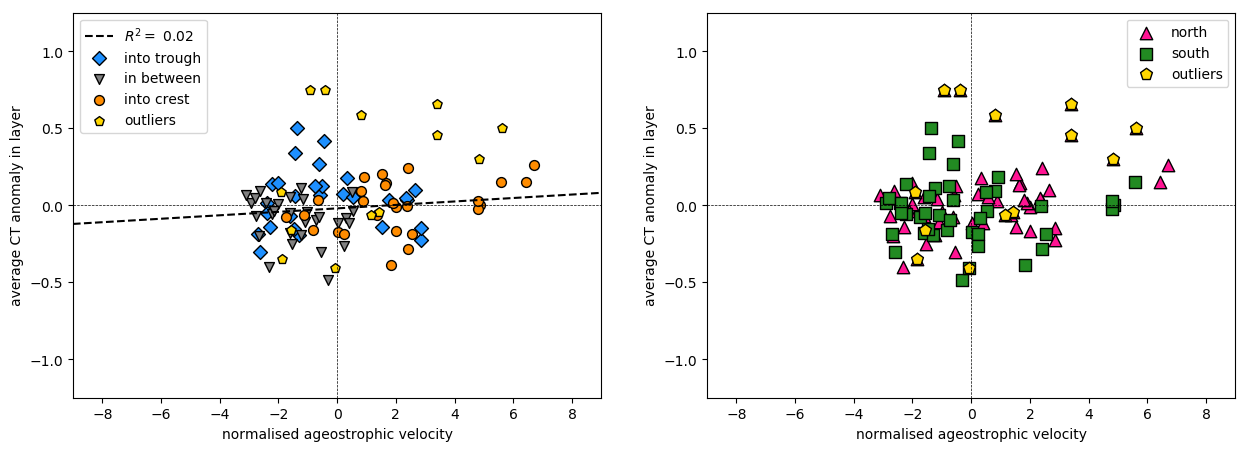

In [21]:
fig, ax = figure(dV, CT_anom, attributes, 'dV_CT', mask=booloutliers)

### keypoints
- If the normalised ageostrophic velocity is positive, it is likely in the crest. If the normalised ageostrophic velocity is negative, it is likely in the trough.
- There is a very weak correlation between the ageostrophic velocity and the anomalously colder temperatures in between trough and crest. 
- Remarkable, in between trough and crest the average temperature anomaly is predominantly negative, which suggests a cooling between trough and crest as a result of the divergence in the ageostrophic velocity between trough and crest.
- Question is where does this cooling come from, from below or from the south considering that the heaving term is negligible?

## layer thickness anomaly against ageostrophic velocity vectors

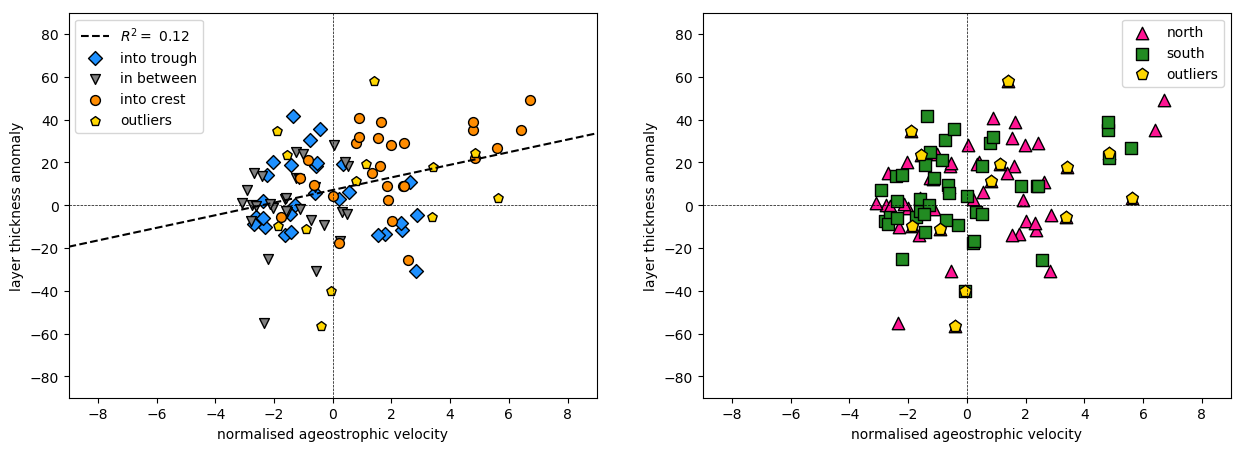

In [22]:
fig, ax = figure(dV, lt_anom, attributes, 'dV_lt', mask=booloutliers)

## Rotation between geostrophic streamlines and ADCP velocity vector direction

(137, 145)

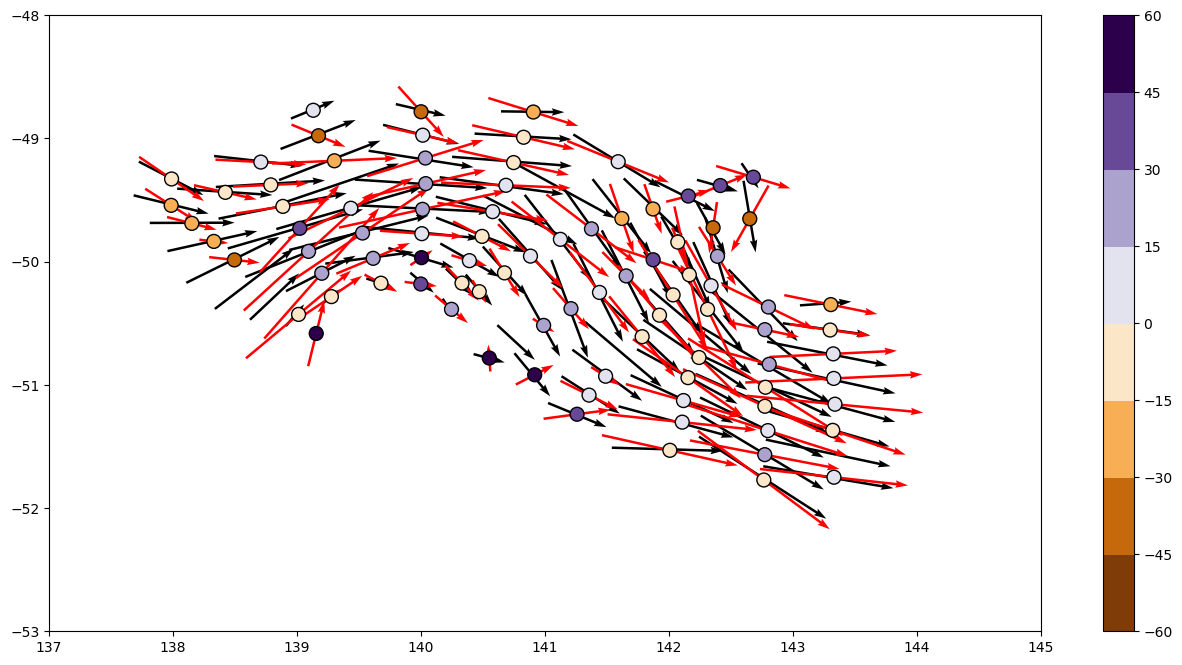

In [23]:
cmap = plt.cm.PuOr

fig, ax = plt.subplots(figsize=(16,8))
ax.quiver(ssh_ctd['longitude'], ssh_ctd['latitude'], 
          ssh_ctd['ugos'],ssh_ctd['vgos'], 
          width=2.5e-2, units='inches', scale=0.35, pivot='mid', color='k')

mask = np.isnan(adcp_mld['u_mld']) | np.isnan(adcp_mld['v_mld'])
ax.quiver(adcp_ctd['lon_ctd'].values[~mask][2:], adcp_ctd['lat_ctd'].values[~mask][2:], 
          adcp_mld['u_mld'][~mask][2:], adcp_mld['v_mld'][~mask][2:], 
          width=2.5e-2, units='inches', scale=0.35, pivot='mid', color='r')


ddir = (adcp_mld['dir_mld'].values - ssh_ctd['dir'].values) * (180 / np.pi)
ddir = np.ma.masked_invalid(ddir)
norm = mcolors.BoundaryNorm(np.linspace(-60, 60, 9), cmap.N)
# dori = orimldmean - orientation_geos
# norm = mcolors.BoundaryNorm(np.linspace(-np.pi/3, np.pi/3, 9), plt.cm.PuOr.N)
scat = ax.scatter(adcp_ctd['lon_ctd'], adcp_ctd['lat_ctd'], 
                  c=ddir, s=100, edgecolors='k',
                  cmap=cmap, norm=norm)

fig.colorbar(scat)

ax.set_ylim([-53, -48])
ax.set_xlim([137, 145])

## Average temperature against rotation between ADCP and geostrophic velocity vectors

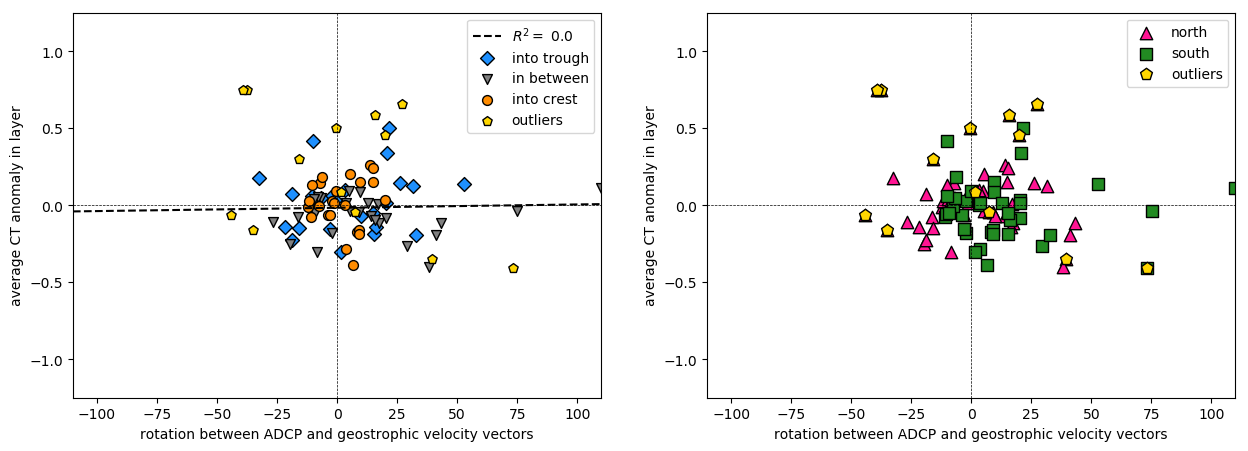

In [24]:
fig, ax = figure(ddir, CT_anom, attributes, 'ddir_CT', mask=booloutliers)

## Summary results

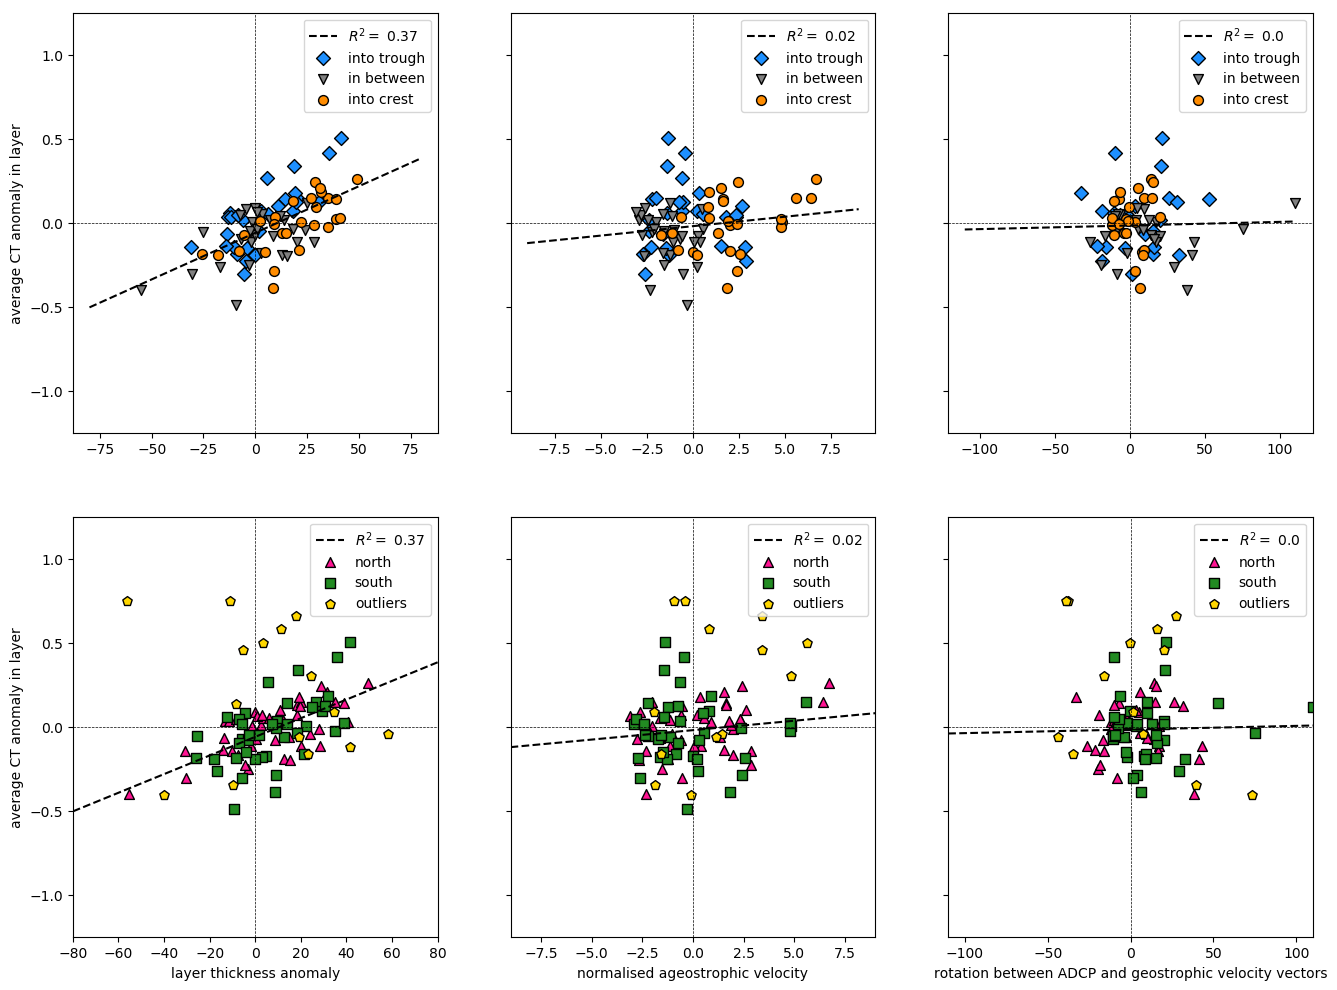

In [25]:
rows, cols = 2, 3

fig, ax = plt.subplots(rows, cols, figsize=(16,12), sharey=True)

areas = ['into trough', 'in between', 'into crest']
for area in areas:
    istat, color, marker = front_loc[area]
    if area is not 'outliers':
        istat = [i for i in istat if i not in ioutliers]
    ax[0, 0].scatter(lt_anom[istat], CT_anom[istat], facecolors=color, edgecolors='k', marker=marker, s=50, label=area)
    ax[0, 1].scatter(dV[istat], CT_anom[istat], facecolors=color, edgecolors='k', marker=marker, s=50, label=area)
    ax[0, 2].scatter(ddir[istat], CT_anom[istat], facecolors=color, edgecolors='k', marker=marker, s=50, label=area)

#     ax[1, 0].scatter(dV[istat], lt_anom[istat], facecolors=color, marker=marker, label=area)
#     ax[1, 1].scatter(ddir[istat], CT_anom[istat], facecolors=color, marker=marker, label=area)

areas = ['north', 'south', 'outliers']
for area in areas:
    istat, color, marker = front_loc[area]
    if area is not 'outliers':
        istat = [i for i in istat if i not in ioutliers]
    ax[1, 0].scatter(lt_anom[istat], CT_anom[istat], facecolors=color, edgecolors='k', marker=marker, s=50, label=area)
    ax[1, 1].scatter(dV[istat], CT_anom[istat], facecolors=color, edgecolors='k', marker=marker, s=50, label=area)
    ax[1, 2].scatter(ddir[istat], CT_anom[istat], facecolors=color, edgecolors='k', marker=marker, s=50, label=area)
    
for iax, attr in enumerate(['lt_CT', 'dV_CT', 'ddir_CT', 'lt_CT', 'dV_CT', 'ddir_CT']):

    row, col = abs(iax) // cols, abs(iax) % cols

    R2, f = Rsquared(vars()[attributes[attr][4]], vars()[attributes[attr][5]], deg=1, mask=booloutliers)
    xi = np.linspace(*attributes[attr][0])
    ax[row, col].plot(xi, f(xi), 'k--', label=r'$R^2 = $ %s' %round(R2,2))

    ax[row, col].axhline(0, linestyle='--', linewidth=0.5, color='k')
    ax[row, col].axvline(0, linestyle='--', linewidth=0.5, color='k')
    
    if row == 1:
        ax[row, col].set_xlim(attributes[attr][0])
        ax[row, col].set_xlabel(attributes[attr][2])
    if col == 0:
        ax[row, col].set_ylim(attributes[attr][1])
        ax[row, col].set_ylabel(attributes[attr][3])
    
    ax[row, col].legend()



In [26]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '07_regression-temp-anomaly' + extension),
                   transparent=True)

### Key points
* Temperature anomalies are diabatic changes (no heaving)
* Strong relation between temperature anomalies and layer thickening/ thinning
* Ageostrophic flow seems to thicken layers into the trough and into the crest causing divergence in the flow 
* There seems to be little cross-frontal flow that could cause the temperature anomalies

### Conclusion
Ageostrophic flow causes divergence in the flow field leading to upwelling and mixing of cold deep water in between trough and crest.

The thickening of the layer into the trough and into the crest could indicate, downwelling and mixing of warmer surface waters

# Quasi geostrophic vorticity
- fdwdz vs layer thickness
- fdwdz vs ugradzeta
- fdwdz vs layer temperature
- okubo-weiss vs temperature

In [27]:
attributes = {
    'lt_vs': [(-80, 80), (-5e-11, 5e-11), 'layer thickness anomaly', qgvb_ctd['fdwdz'].long_name, 'lt_anom', 'vs'],
    'advrv_vs': [(-6e-11, 6e-11), (-6e-11, 6e-11), qgvb_ctd['ugradzeta'].long_name, qgvb_ctd['fdwdz'].long_name, 'advrv', 'vs'],
    'CT_vs': [(-1.0, 1.0), (-5e-11, 5e-11), 'average CT anomaly in layer', qgvb_ctd['fdwdz'].long_name, 'CT_anom', 'vs'],
    'advrv_CT': [(-6e-11, 6e-11), (-1.0, 1.0), qgvb_ctd['ugradzeta'].long_name, 'average CT anomaly in layer'],
    'OW_CT': [(-2.5e-11, 2.5e-11), (-1.0, 1.0), 'Okubo-Weiss parameter', 'average CT anomaly in layer'],
    'OWnorm_CT': [(-5, 5), (-1.0, 1.0), 'normalised Okubo-Weiss parameter', 'average CT anomaly in layer'],
    'OW_lt': [(-2.5e-11, 2.5e-11), (-80, 80), 'Okubo-Weiss parameter', 'layer thickness anomaly'],

}

In [28]:
vs = qgvb_ctd['fdwdz']
advrv = qgvb_ctd['ugradzeta']

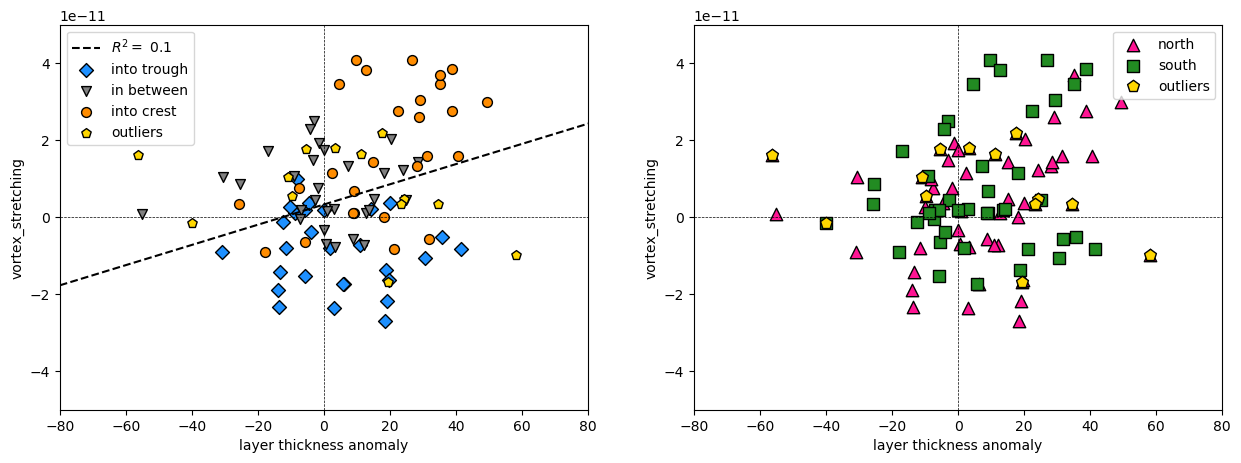

In [29]:
fig, ax = figure(lt_anom, vs, attributes, 'lt_vs', mask=booloutliers)

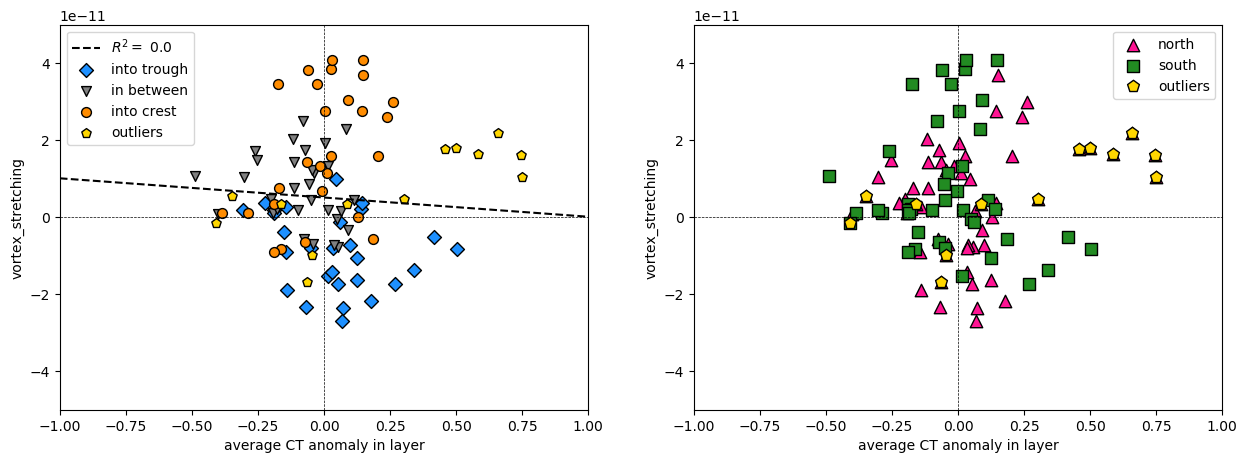

In [30]:
fig, ax = figure(CT_anom, vs, attributes, 'CT_vs', mask=booloutliers)

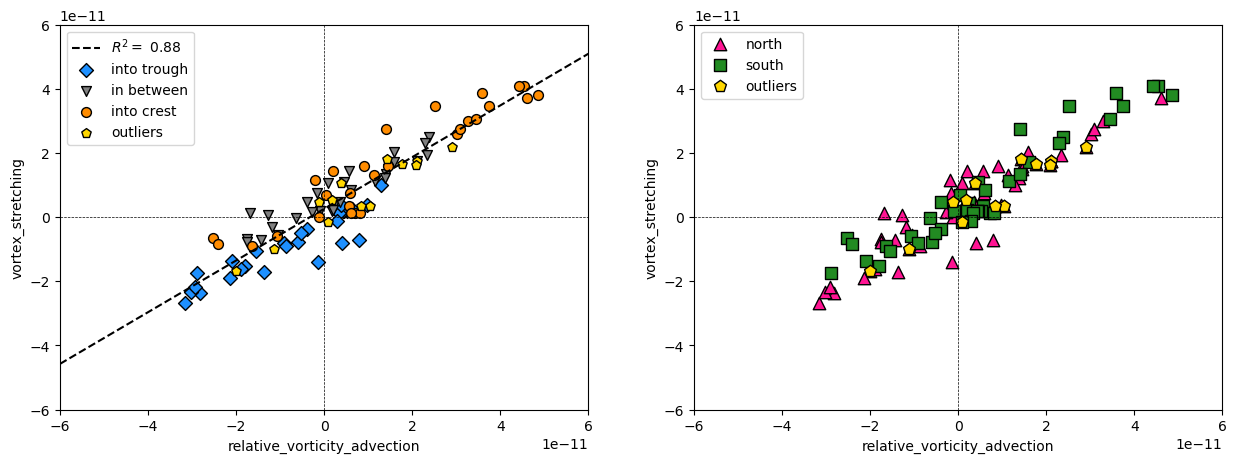

In [31]:
fig, ax = figure(advrv, vs, attributes, 'advrv_vs', mask=booloutliers)

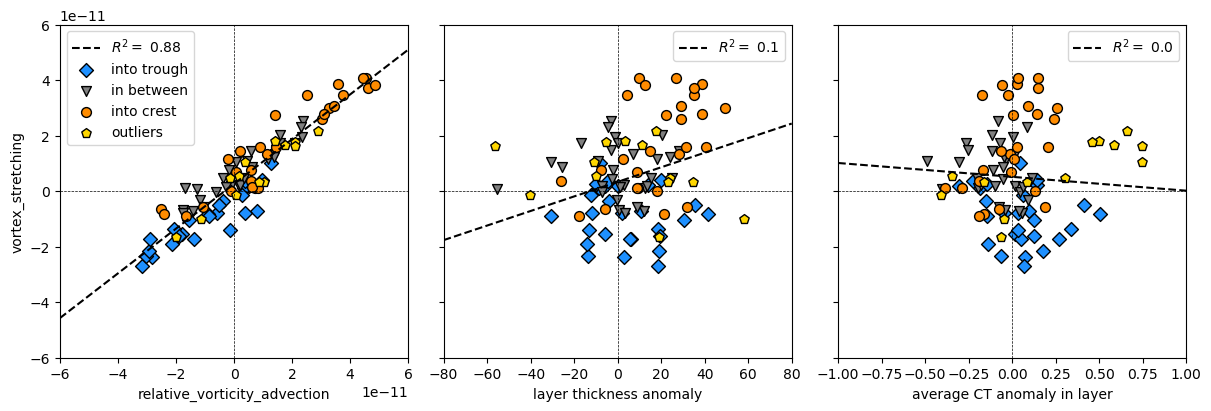

In [32]:
rows, cols = 1, 3

fig, ax = plt.subplots(rows, cols, figsize=(12,4), sharey=True, constrained_layout=True)

areas = ['into trough', 'in between', 'into crest', 'outliers']

#     ax[1].scatter(lt_anom[istat], qgvb_ctd['fdwdz'][istat], facecolors=color, edgecolors='k', marker=marker, s=50, label=area)
#     ax[2].scatter(CT_anom[istat], qgvb_ctd['fdwdz'][istat], facecolors=color, edgecolors='k', marker=marker, s=50, label=area)

for iax, attr in enumerate(['advrv_vs', 'lt_vs', 'CT_vs']):
    
    for area in areas:
        istat, color, marker = front_loc[area]
        if area is not 'outliers':
            istat = [i for i in istat if i not in ioutliers]
        ax[iax].scatter(vars()[attributes[attr][4]][istat], vars()[attributes[attr][5]][istat],
                        facecolors=color, edgecolors='k', marker=marker, s=50, label=area if iax==0 else None)
    
    R2, f = Rsquared(vars()[attributes[attr][4]], vars()[attributes[attr][5]], deg=1, mask=booloutliers)
    xi = np.linspace(*attributes[attr][0])
    ax[iax].plot(xi, f(xi), 'k--', label=r'$R^2 = $ %s' %round(float(R2),2))

    ax[iax].axhline(0, linestyle='--', linewidth=0.5, color='k')
    ax[iax].axvline(0, linestyle='--', linewidth=0.5, color='k')
    
    ax[iax].set_xlim(attributes[attr][0])
    ax[iax].set_xlabel(attributes[attr][2])
    if iax == 0:
        ax[iax].set_ylim(attributes[attr][1])
        ax[iax].set_ylabel(attributes[attr][3])
    
    ax[iax].legend()



In [33]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '10_regression-vorticity' + extension),
                   transparent=True)

## Okubo-Weiss parameter

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0.5, 1.0, 'average CT anomaly in layer')

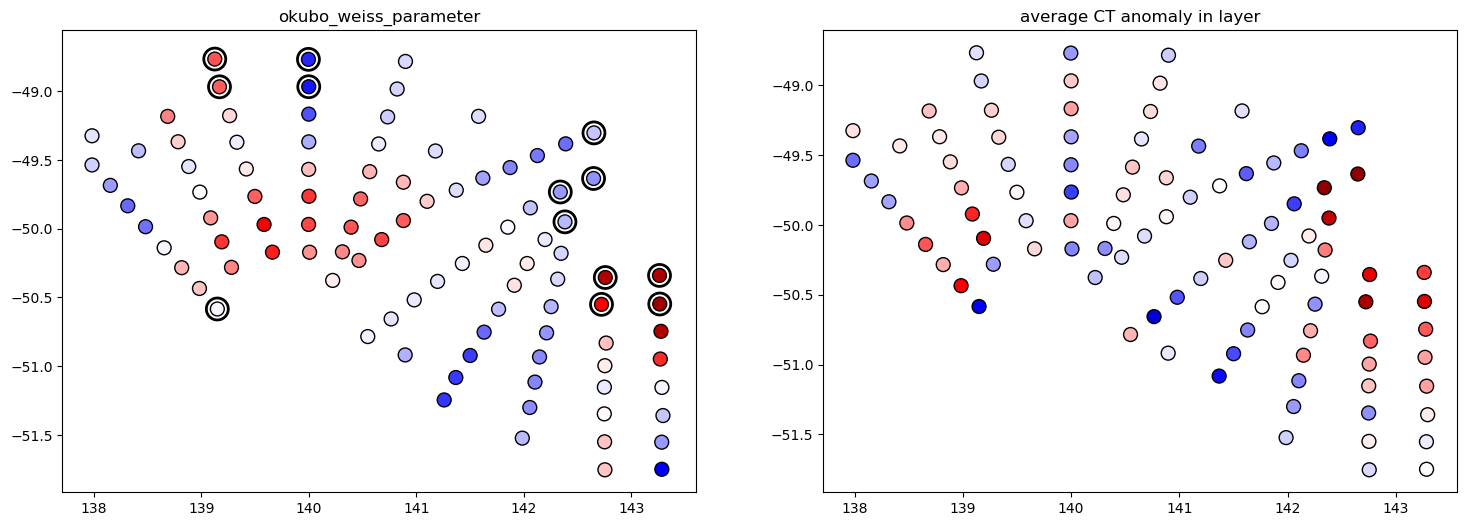

In [35]:
vmin, vmax = -2.5e-11, 2.5e-11

fig, ax = plt.subplots(1,2, figsize=(18,6))

ax[0].scatter(lon_ctd[2:], lat_ctd[2:], c=qgvb_ctd['ow'][2:], 
            edgecolors='k', s=100, cmap=plt.cm.seismic_r, vmin=vmin, vmax=vmax)

ax[1].scatter(lon_ctd[2:], lat_ctd[2:], c=CT_anom[2:], 
            edgecolors='k', s=100, cmap=plt.cm.seismic, vmin=-0.8, vmax=0.8)

ax[0].scatter(lon_ctd[ioutliers][2:], lat_ctd[ioutliers][2:],
              s=250, linewidth=2, facecolors='none', edgecolors='k', label='weird')

ax[0].set_title(qgvb_ctd['ow'].long_name)
ax[1].set_title('average CT anomaly in layer')

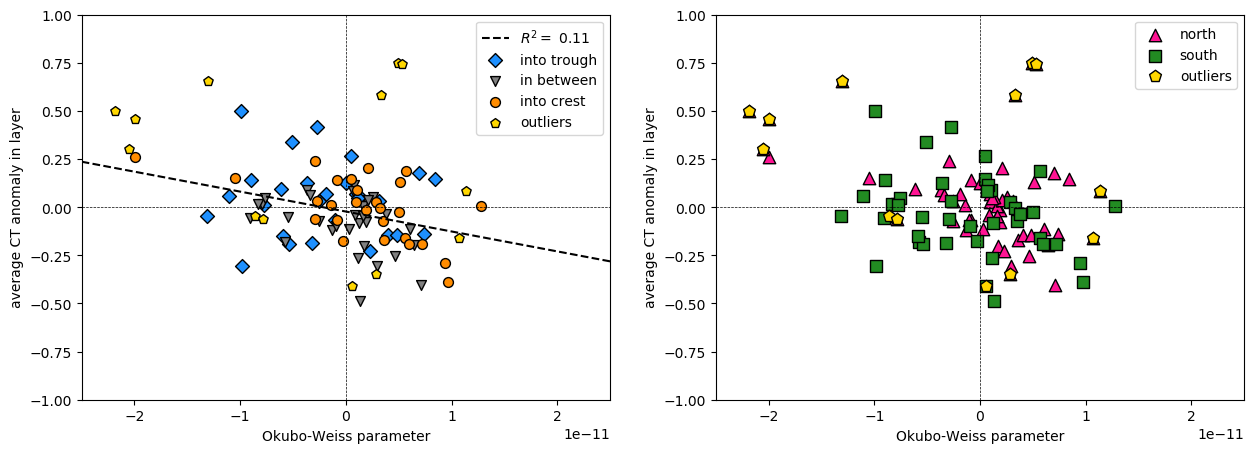

In [36]:
fig, ax = figure(qgvb_ctd['ow'], CT_anom, attributes, 'OW_CT', mask=booloutliers)

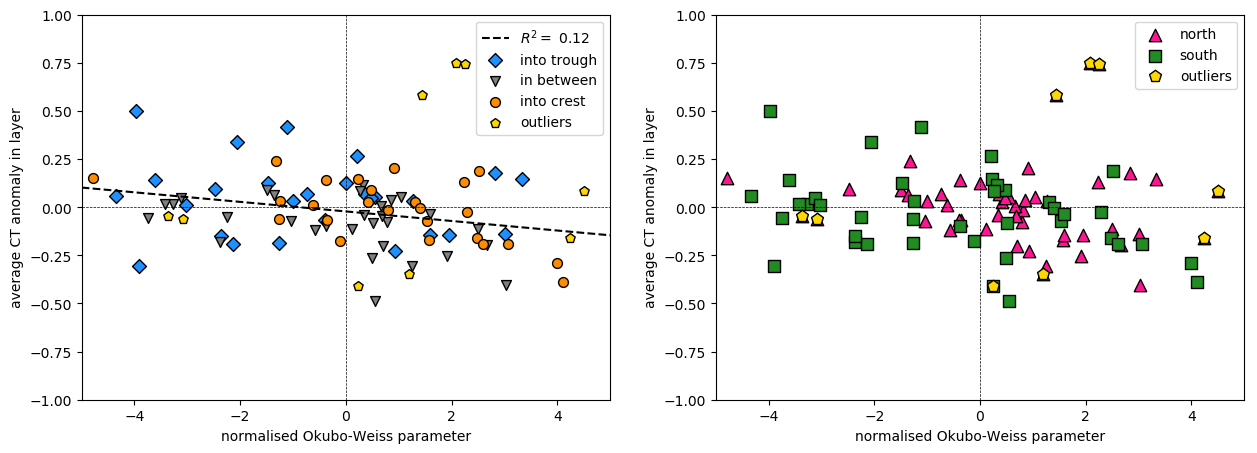

In [37]:
fig, ax = figure(qgvb_ctd['ow_norm'], CT_anom, attributes, 'OWnorm_CT', mask=booloutliers)

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


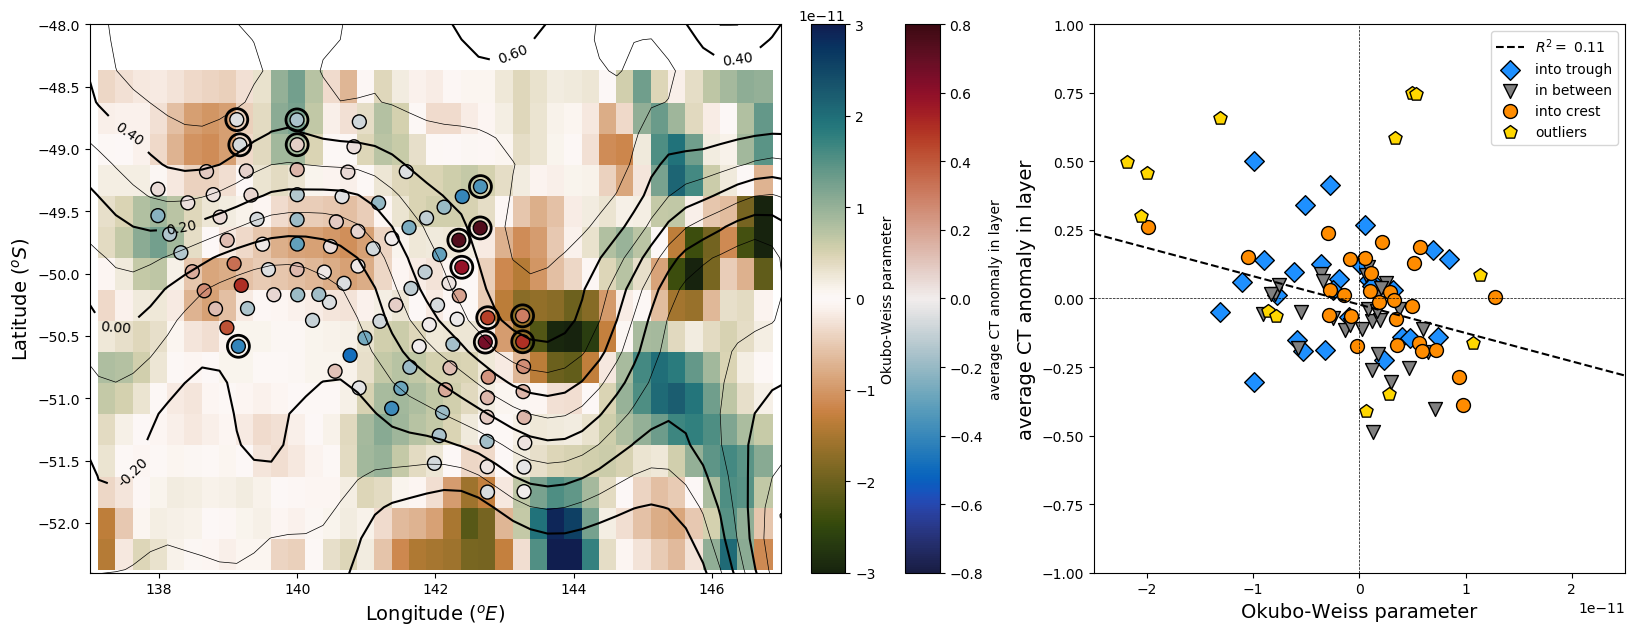

In [38]:
ssh_contours = np.linspace(-0.4, 0.6, 11)
vmin, vmax = -3e-11, 3e-11
axis=0
# vmin, vmax = Wcenter + W0 - 1e-12, Wcenter + W0 + 1e-12

rows, cols = 1, 2

fig, (ax0, ax1) = plt.subplots(rows, cols, figsize=(18, 8), gridspec_kw={'width_ratios': [8, 5]}, constrained_layout=True)
fig.tight_layout(pad=8)

# plot Okubo-Weiss parameter
pcol = ax0.pcolor(qgvb.longitude, qgvb.latitude, qgvb.ow.mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.tarn)
# cbar = plt.colorbar(pcol, ax=ax[0])
# ax.set_title('Okubo-Weiss parameter')


# plot sea surface height contours
ct = ax0.contour(ssh.longitude, ssh.latitude, ssh.adt.mean('time'),
                ssh_contours, colors='k', linestyles='solid', linewidths=0.5)
for ib, b in enumerate(ssh_contours):
    if b in ssh_contours[0::2]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=1.5)
ax0.clabel(ct, ssh_contours[0::2], inline=1, fontsize=10, fmt='%.2f')

# # plot 
# quiv = ax0.quiver(ssh.longitude, ssh.latitude, ssh.ugos.mean('time'), ssh.vgos.mean('time'), 
#                  units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='gray')

# average temperature anomaly in SAMW layer
scat = ax0.scatter(lon_ctd[2:], lat_ctd[2:], c=CT_anom[2:], 
            edgecolors='k', s=100, cmap=cmo.cm.balance, vmin=-0.8, vmax=0.8)


divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.3)
cb_pcol = plt.colorbar(pcol, cax=cax)

cax = divider.append_axes("right", size="5%", pad=0.6)
cb_scat = plt.colorbar(scat, cax=cax)

cb_pcol.set_label(attributes['OW_CT'][2])
cb_scat.set_label(attributes['OW_CT'][3])

ax0.scatter(lon_ctd[ioutliers][2:], lat_ctd[ioutliers][2:], 
              s=250, linewidth=2, facecolors='none', edgecolors='k')


ax0.set_xlim([137, 147])
ax0.set_ylim([-52.4, -48])
ax0.set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
ax0.set_ylabel(r'Latitude ($^oS$)', fontsize=fs_large)


areas = ['into trough', 'in between', 'into crest', 'outliers']
for area in areas:
    istat, color, marker = front_loc[area]
    if area is not 'outliers':
        istat = [i for i in istat if i not in ioutliers]
    ax1.scatter(qgvb_ctd['ow'][istat], CT_anom[istat], 
                facecolors=color, edgecolors='k', marker=marker, s=100, label=area)

R2, f = Rsquared(qgvb_ctd['ow'], CT_anom, deg=1, mask=booloutliers)
xi = np.linspace(*attributes['OW_CT'][0])
ax1.plot(xi, f(xi), 'k--', label=r'$R^2 = $ %s' %round(R2,2))

ax1.axhline(0, linestyle='--', linewidth=0.5, color='k')
ax1.axvline(0, linestyle='--', linewidth=0.5, color='k')
ax1.set_xlim(attributes['OW_CT'][0])
ax1.set_ylim(attributes['OW_CT'][1])
ax1.set_xlabel(attributes['OW_CT'][2], fontsize=fs_large)
ax1.set_ylabel(attributes['OW_CT'][3], fontsize=fs_large)
ax1.legend()


In [39]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '11_regression-okubo-weiss' + extension),
                   transparent=True)